In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import warnings
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.data_processing import preprocess_text
warnings.filterwarnings('ignore')

In [7]:
twitts_train = pd.read_csv("../data/twitter_training.csv")
twitts_valid = pd.read_csv("../data/twitter_validation.csv")

In [8]:
column_name=['tweetID','entity','sentiment','tweet_content']
twitts_train.columns=column_name
twitts_valid.columns=column_name

In [9]:
# see the  duplicate tweets
print("Number of duplicate tweets in training set:", twitts_train.duplicated().sum())
print("Number of duplicate tweets in validation set:", twitts_valid.duplicated().sum())
# see the nan values
print("Number of nan values in training set:", twitts_train.isnull().sum().sum())
print("Number of nan values in validation set:", twitts_valid.isnull().sum().sum())


Number of duplicate tweets in training set: 2700
Number of duplicate tweets in validation set: 0
Number of nan values in training set: 686
Number of nan values in validation set: 0


In [10]:
# clean the duplicated tweets
twitts_train = twitts_train.drop_duplicates(subset=['tweet_content'])
twitts_valid = twitts_valid.drop_duplicates(subset=['tweet_content'])

# clean the empty tweets
twitts_train = twitts_train.dropna(subset=['tweet_content'])
twitts_valid = twitts_valid.dropna(subset=['tweet_content'])

# lower case the sentiment labels
twitts_train['sentiment'] = twitts_train['sentiment'].str.lower()
twitts_valid['sentiment'] = twitts_valid['sentiment'].str.lower()

# Remove the irrelevant sentiment label
twitts_train = twitts_train[twitts_train['sentiment'].isin(['positive', 'negative', 'neutral'])]
twitts_valid = twitts_valid[twitts_valid['sentiment'].isin(['positive', 'negative', 'neutral'])]

# Reset index after cleaning
twitts_train.reset_index(drop=True, inplace=True)
twitts_valid.reset_index(drop=True, inplace=True)

print("Number of tweets in training set after cleaning:", len(twitts_train))
print("Number of tweets in validation set after cleaning:", len(twitts_valid))

Number of tweets in training set after cleaning: 57274
Number of tweets in validation set after cleaning: 827


In [11]:
# see the  duplicate tweets
print("Number of duplicate tweets in training set:", twitts_train.duplicated().sum())
print("Number of duplicate tweets in validation set:", twitts_valid.duplicated().sum())
# see the nan values
print("Number of nan values in training set:", twitts_train.isnull().sum().sum())
print("Number of nan values in validation set:", twitts_valid.isnull().sum().sum())


Number of duplicate tweets in training set: 0
Number of duplicate tweets in validation set: 0
Number of nan values in training set: 0
Number of nan values in validation set: 0


In [12]:
twitts_train['tweet_content'] = twitts_train['tweet_content'].apply(preprocess_text)
twitts_valid['tweet_content'] = twitts_valid['tweet_content'].apply(preprocess_text)

In [13]:
analyzer = SentimentIntensityAnalyzer()

def sentiment_analysis(text):
    if pd.isna(text):
        return 0, 0, 0, 0
    scores = analyzer.polarity_scores(text)
    return scores['compound'], scores['pos'], scores['neg'], scores['neu']
    

In [14]:
print("Aplicando análise de sentimentos VADER nos dados de treino...")
sentiment_results_train = twitts_train['tweet_content'].apply(sentiment_analysis)
twitts_train['compound'] = [result[0] for result in sentiment_results_train]
twitts_train['positive'] = [result[1] for result in sentiment_results_train]
twitts_train['negative'] = [result[2] for result in sentiment_results_train]
twitts_train['neutral'] = [result[3] for result in sentiment_results_train]

print("Aplicando análise de sentimentos VADER nos dados de validação...")
sentiment_results_valid = twitts_valid['tweet_content'].apply(sentiment_analysis)
twitts_valid['compound'] = [result[0] for result in sentiment_results_valid]
twitts_valid['positive'] = [result[1] for result in sentiment_results_valid]
twitts_valid['negative'] = [result[2] for result in sentiment_results_valid]
twitts_valid['neutral'] = [result[3] for result in sentiment_results_valid]

Aplicando análise de sentimentos VADER nos dados de treino...
Aplicando análise de sentimentos VADER nos dados de validação...


In [15]:
def classify_sentiment(compound_score, threshold=0.05):
    if compound_score >= threshold:
        return 'Positive'
    elif compound_score <= -threshold:
        return 'Negative'
    else:
        return 'Neutral'

twitts_train['predicted_sentiment'] = twitts_train['compound'].apply(
    lambda x: classify_sentiment(x, threshold=0.05)
)
twitts_valid['predicted_sentiment'] = twitts_valid['compound'].apply(
    lambda x: classify_sentiment(x, threshold=0.05)
)

In [16]:
print(f"Treino - Média: {twitts_train['compound'].mean():.3f}, "
      f"Desvio: {twitts_train['compound'].std():.3f}")
print(f"Validação - Média: {twitts_valid['compound'].mean():.3f}, "
      f"Desvio: {twitts_valid['compound'].std():.3f}")
print()

print("Scores Positivos - Estatísticas descritivas:")
print(f"Treino - Média: {twitts_train['positive'].mean():.3f}, "
      f"Desvio: {twitts_train['positive'].std():.3f}")
print(f"Validação - Média: {twitts_valid['positive'].mean():.3f}, "
      f"Desvio: {twitts_valid['positive'].std():.3f}")
print()

print("Scores Negativos - Estatísticas descritivas:")
print(f"Treino - Média: {twitts_train['negative'].mean():.3f}, "
      f"Desvio: {twitts_train['negative'].std():.3f}")
print(f"Validação - Média: {twitts_valid['negative'].mean():.3f}, "
      f"Desvio: {twitts_valid['negative'].std():.3f}")

Treino - Média: 0.064, Desvio: 0.540
Validação - Média: 0.054, Desvio: 0.570

Scores Positivos - Estatísticas descritivas:
Treino - Média: 0.160, Desvio: 0.180
Validação - Média: 0.157, Desvio: 0.175

Scores Negativos - Estatísticas descritivas:
Treino - Média: 0.127, Desvio: 0.164
Validação - Média: 0.134, Desvio: 0.174


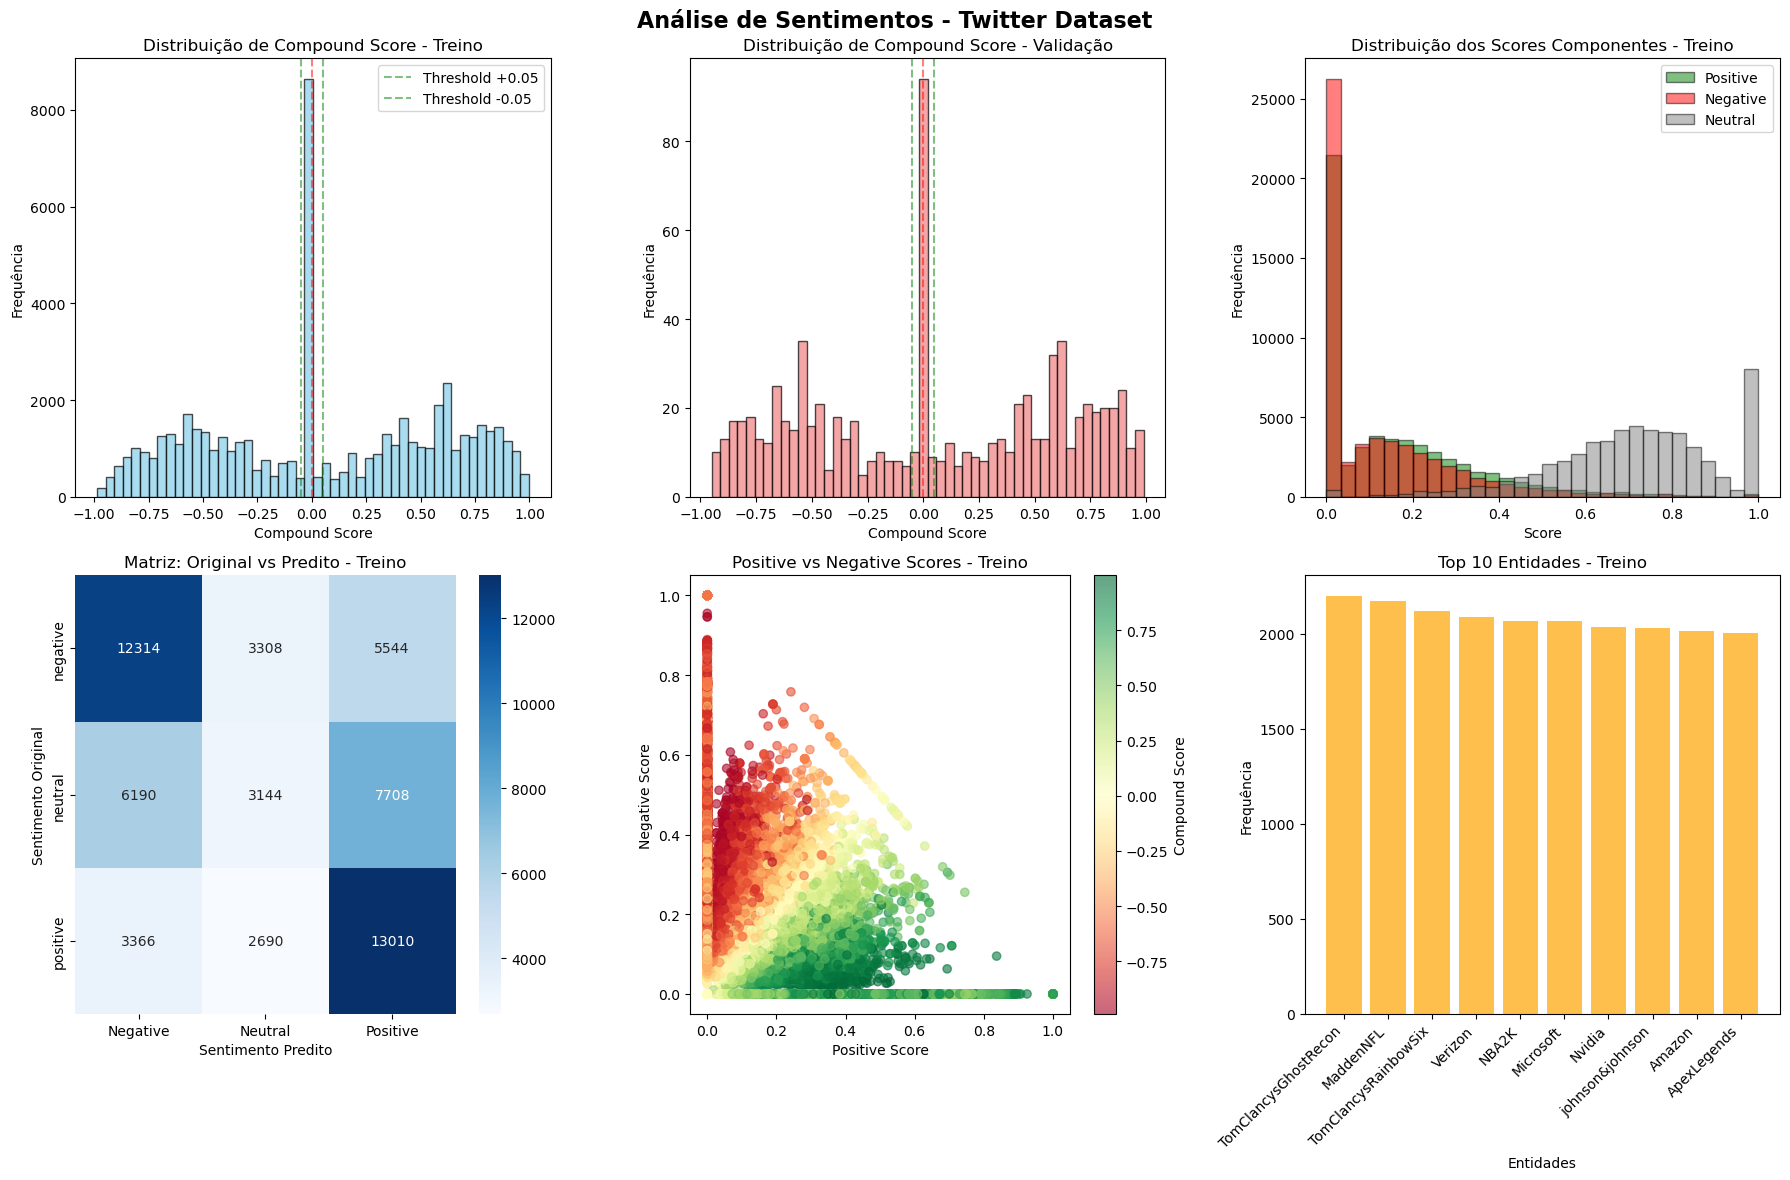

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Análise de Sentimentos - Twitter Dataset', fontsize=16, fontweight='bold')

# 1. Distribuição de compound score (treino)
axes[0, 0].hist(twitts_train['compound'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribuição de Compound Score - Treino')
axes[0, 0].set_xlabel('Compound Score')
axes[0, 0].set_ylabel('Frequência')
axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.5)
axes[0, 0].axvline(x=0.05, color='green', linestyle='--', alpha=0.5, label='Threshold +0.05')
axes[0, 0].axvline(x=-0.05, color='green', linestyle='--', alpha=0.5, label='Threshold -0.05')
axes[0, 0].legend()

# 2. Distribuição de compound score (validação)
axes[0, 1].hist(twitts_valid['compound'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Distribuição de Compound Score - Validação')
axes[0, 1].set_xlabel('Compound Score')
axes[0, 1].set_ylabel('Frequência')
axes[0, 1].axvline(x=0, color='red', linestyle='--', alpha=0.5)
axes[0, 1].axvline(x=0.05, color='green', linestyle='--', alpha=0.5)
axes[0, 1].axvline(x=-0.05, color='green', linestyle='--', alpha=0.5)

# 3. Distribuição dos scores componentes (treino)
axes[0, 2].hist(twitts_train['positive'], bins=30, alpha=0.5, color='green', label='Positive', edgecolor='black')
axes[0, 2].hist(twitts_train['negative'], bins=30, alpha=0.5, color='red', label='Negative', edgecolor='black')
axes[0, 2].hist(twitts_train['neutral'], bins=30, alpha=0.5, color='gray', label='Neutral', edgecolor='black')
axes[0, 2].set_title('Distribuição dos Scores Componentes - Treino')
axes[0, 2].set_xlabel('Score')
axes[0, 2].set_ylabel('Frequência')
axes[0, 2].legend()

# 4. Comparação de sentimentos originais vs preditos (treino)
sentiment_comparison = pd.crosstab(twitts_train['sentiment'], 
                                  twitts_train['predicted_sentiment'])
sns.heatmap(sentiment_comparison, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_title('Matriz: Original vs Predito - Treino')
axes[1, 0].set_xlabel('Sentimento Predito')
axes[1, 0].set_ylabel('Sentimento Original')

# 5. Scatter plot: Positive vs Negative scores
scatter = axes[1, 1].scatter(twitts_train['positive'], twitts_train['negative'], 
                           alpha=0.6, c=twitts_train['compound'], cmap='RdYlGn')
axes[1, 1].set_title('Positive vs Negative Scores - Treino')
axes[1, 1].set_xlabel('Positive Score')
axes[1, 1].set_ylabel('Negative Score')
plt.colorbar(scatter, ax=axes[1, 1], label='Compound Score')

# 6. Distribuição por entidade
entity_counts = twitts_train['entity'].value_counts().head(10)
axes[1, 2].bar(range(len(entity_counts)), entity_counts.values, color='orange', alpha=0.7)
axes[1, 2].set_title('Top 10 Entidades - Treino')
axes[1, 2].set_xlabel('Entidades')
axes[1, 2].set_ylabel('Frequência')
axes[1, 2].set_xticks(range(len(entity_counts)))
axes[1, 2].set_xticklabels(entity_counts.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [18]:
def map_original_sentiment(sentiment):
    """Mapear sentimentos originais para formato padronizado"""
    sentiment = str(sentiment).lower()
    if 'positive' in sentiment:
        return 'Positive'
    elif 'negative' in sentiment:
        return 'Negative'
    else:
        return 'Neutral'

# Tentar mapear sentimentos originais
twitts_train['original_mapped'] = twitts_train['sentiment'].apply(map_original_sentiment)
twitts_valid['original_mapped'] = twitts_valid['sentiment'].apply(map_original_sentiment)



In [19]:

print("\nRelatório de classificação (Treino):")
print(classification_report(twitts_train['original_mapped'], 
                            twitts_train['predicted_sentiment']))


Relatório de classificação (Treino):
              precision    recall  f1-score   support

    Negative       0.56      0.58      0.57     21166
     Neutral       0.34      0.18      0.24     17042
    Positive       0.50      0.68      0.57     19066

    accuracy                           0.50     57274
   macro avg       0.47      0.48      0.46     57274
weighted avg       0.48      0.50      0.47     57274



In [20]:

print("\nRelatório de classificação (Validação):")
print(classification_report(twitts_valid['original_mapped'], 
                            twitts_valid['predicted_sentiment']))



Relatório de classificação (Validação):
              precision    recall  f1-score   support

    Negative       0.48      0.60      0.54       266
     Neutral       0.41      0.15      0.22       285
    Positive       0.49      0.70      0.58       276

    accuracy                           0.48       827
   macro avg       0.46      0.48      0.45       827
weighted avg       0.46      0.48      0.44       827



In [21]:
# Tweets mais positivos
most_positive = twitts_train.nlargest(5, 'compound')[['tweet_content', 'compound', 'positive', 'negative', 'predicted_sentiment']]
print("TOP 5 TWEETS MAIS POSITIVOS:")
for idx, row in most_positive.iterrows():
    print(f"Compound: {row['compound']:.3f} | Pos: {row['positive']:.3f} | Neg: {row['negative']:.3f} | Sentimento: {row['predicted_sentiment']}")
    print(f"Tweet: {row['tweet_content'][:100]}...")
    print("-" * 80)

TOP 5 TWEETS MAIS POSITIVOS:
Compound: 0.998 | Pos: 0.544 | Neg: 0.000 | Sentimento: Positive
Tweet: playing in league tile Clothing is SO enjoyable playing in league tile Clothing is SO enjoyable play...
--------------------------------------------------------------------------------
Compound: 0.994 | Pos: 0.485 | Neg: 0.077 | Sentimento: Positive
Tweet: I said I wouldn t get a ps but fucking hell GT seems like its original GT which is a good thing a re...
--------------------------------------------------------------------------------
Compound: 0.991 | Pos: 0.677 | Neg: 0.000 | Sentimento: Positive
Tweet: I love you I love you I love you I love you I love you I love you I love you I love you I love you...
--------------------------------------------------------------------------------
Compound: 0.991 | Pos: 0.569 | Neg: 0.000 | Sentimento: Positive
Tweet: I played this interesting Quiz show on the Amazon Play games online at Amazon FunZone B Itd s very e...
--------------------------

In [22]:
most_negative = twitts_train.nsmallest(5, 'compound')[['tweet_content', 'compound', 'positive', 'negative', 'predicted_sentiment']]
print("\nTOP 5 TWEETS MAIS NEGATIVOS:")
for idx, row in most_negative.iterrows():
    print(f"Compound: {row['compound']:.3f} | Pos: {row['positive']:.3f} | Neg: {row['negative']:.3f} | Sentimento: {row['predicted_sentiment']}")
    print(f"Tweet: {row['tweet_content'][:100]}...")
    print("-" * 80)


TOP 5 TWEETS MAIS NEGATIVOS:
Compound: -0.988 | Pos: 0.000 | Neg: 0.566 | Sentimento: Negative
Tweet: FUCK OR YOU FUCK TO YOU and FUCK YOU TO FUCK YOU FUCK YOU FUCK ON YOU U GUYS FUCKING LIE TO US AND G...
--------------------------------------------------------------------------------
Compound: -0.986 | Pos: 0.000 | Neg: 0.426 | Sentimento: Negative
Tweet: Hey But Not Say what says the actual ruthless fuck is wrong with you Why the fuck are you hiding NOT...
--------------------------------------------------------------------------------
Compound: -0.986 | Pos: 0.069 | Neg: 0.430 | Sentimento: Negative
Tweet: Call of Duty Black Ops is the worst fucking game ever The game board is already ruined completely by...
--------------------------------------------------------------------------------
Compound: -0.985 | Pos: 0.000 | Neg: 0.627 | Sentimento: Negative
Tweet: Welp there it is no Ps for me or Fuck u All your Fucking fault for dropping her damn Fucking crazy a...
-------------------

In [23]:
entity_sentiment = twitts_train.groupby('entity').agg({
    'compound': ['mean', 'std', 'count'],
    'positive': 'mean',
    'negative': 'mean',
    'neutral': 'mean'
}).round(3)

entity_sentiment.columns = ['Compound_Média', 'Compound_Desvio', 'Quantidade', 'Positive_Média', 'Negative_Média', 'Neutral_Média']
entity_sentiment = entity_sentiment.sort_values('Compound_Média', ascending=False)

# Display top entities by sentiment
print("\nTop 10 entidades por sentiment (ordenado por Compound Score médio):")
print(entity_sentiment.head(10))


Top 10 entidades por sentiment (ordenado por Compound Score médio):
                 Compound_Média  Compound_Desvio  Quantidade  Positive_Média  \
entity                                                                         
Amazon                    0.276            0.574        2014           0.248   
AssassinsCreed            0.239            0.516        1852           0.197   
Hearthstone               0.235            0.546        1933           0.199   
Borderlands               0.213            0.540        1944           0.192   
WorldOfCraft              0.201            0.520        2002           0.184   
CS-GO                     0.147            0.550        1507           0.201   
Xbox(Xseries)             0.137            0.516        1479           0.171   
LeagueOfLegends           0.132            0.532        1869           0.179   
Cyberpunk2077             0.129            0.493        1660           0.179   
Google                    0.123            0.548   

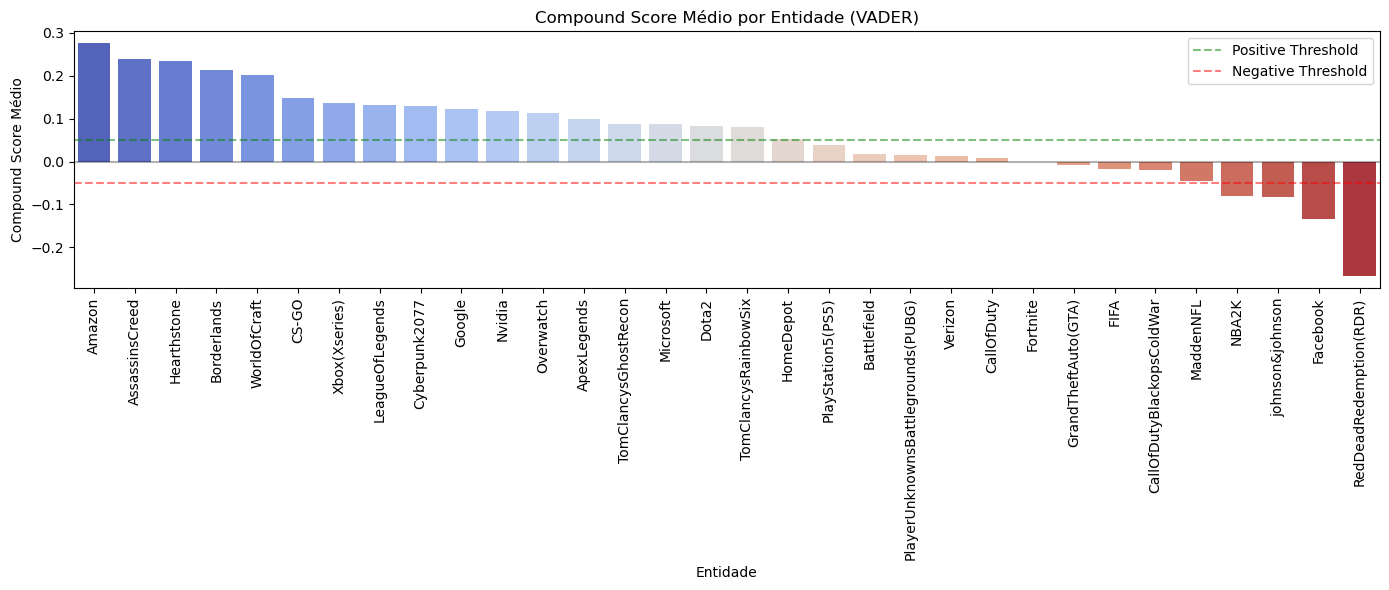

In [24]:
plt.figure(figsize=(14, 6))
sns.barplot(x=entity_sentiment.index, y=entity_sentiment['Compound_Média'], palette='coolwarm')
plt.title('Compound Score Médio por Entidade (VADER)')
plt.xlabel('Entidade')
plt.ylabel('Compound Score Médio')
plt.xticks(ticks=np.arange(len(entity_sentiment.index)), labels=entity_sentiment.index, rotation=90, ha='center')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axhline(y=0.05, color='green', linestyle='--', alpha=0.5, label='Positive Threshold')
plt.axhline(y=-0.05, color='red', linestyle='--', alpha=0.5, label='Negative Threshold')
plt.legend()
plt.tight_layout()
plt.show()

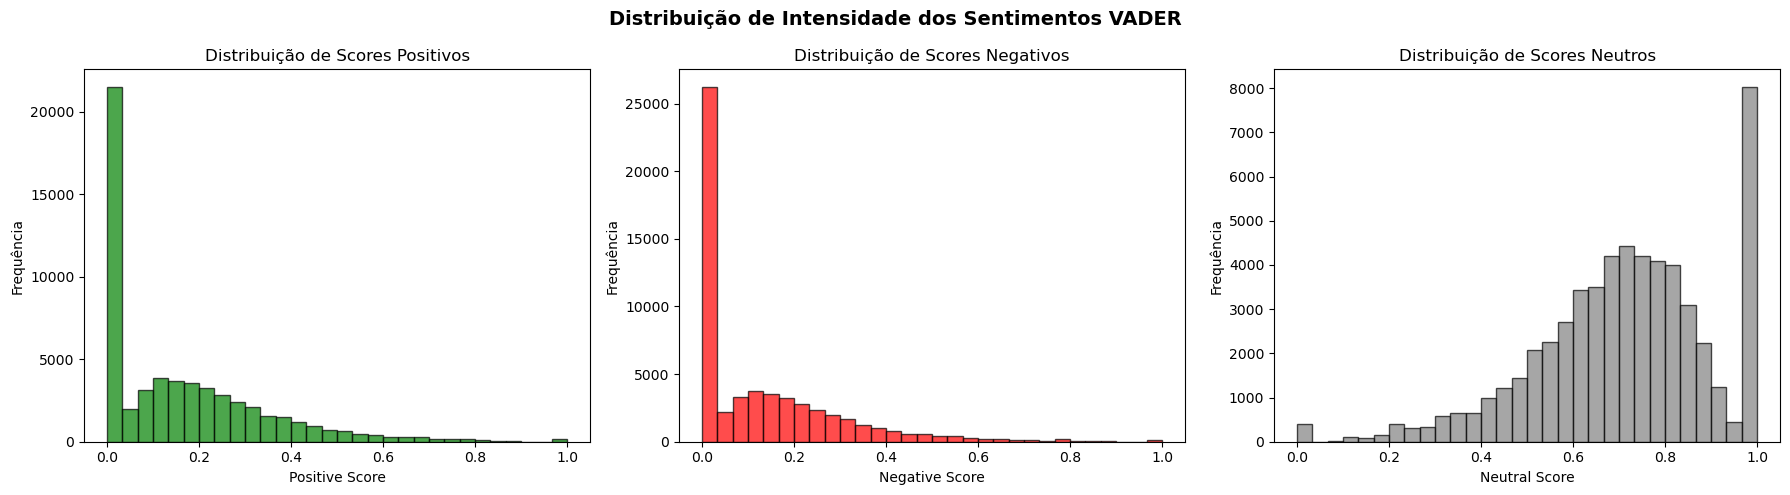

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Distribuição de Intensidade dos Sentimentos VADER', fontsize=14, fontweight='bold')

# Distribution of positive scores
axes[0].hist(twitts_train['positive'], bins=30, alpha=0.7, color='green', edgecolor='black')
axes[0].set_title('Distribuição de Scores Positivos')
axes[0].set_xlabel('Positive Score')
axes[0].set_ylabel('Frequência')

# Distribution of negative scores
axes[1].hist(twitts_train['negative'], bins=30, alpha=0.7, color='red', edgecolor='black')
axes[1].set_title('Distribuição de Scores Negativos')
axes[1].set_xlabel('Negative Score')
axes[1].set_ylabel('Frequência')

# Distribution of neutral scores
axes[2].hist(twitts_train['neutral'], bins=30, alpha=0.7, color='gray', edgecolor='black')
axes[2].set_title('Distribuição de Scores Neutros')
axes[2].set_xlabel('Neutral Score')
axes[2].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

In [26]:
thresholds = [0.01, 0.05, 0.1, 0.15, 0.2]
print("Comparação de performance com diferentes thresholds:")
print("Threshold | Accuracy (Train) | Accuracy (Valid)")
print("-" * 45)

for threshold in thresholds:
    # Apply classification with different thresholds
    train_pred = twitts_train['compound'].apply(
        lambda x: classify_sentiment(x, threshold=threshold)
    )
    valid_pred = twitts_valid['compound'].apply(
        lambda x: classify_sentiment(x, threshold=threshold)
    )
    
    # Calculate accuracies
    train_acc = accuracy_score(twitts_train['original_mapped'], train_pred)
    valid_acc = accuracy_score(twitts_valid['original_mapped'], valid_pred)
    
    print(f"{threshold:8.2f} | {train_acc:15.3f} | {valid_acc:14.3f}")

Comparação de performance com diferentes thresholds:
Threshold | Accuracy (Train) | Accuracy (Valid)
---------------------------------------------
    0.01 |           0.499 |          0.485
    0.05 |           0.497 |          0.479
    0.10 |           0.495 |          0.480
    0.15 |           0.490 |          0.472
    0.20 |           0.488 |          0.476
